In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import calc_embeddings, plot_embeddings
from utils import TripletMNIST, TripletLoss

### Architecture

In [95]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def embed(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def embed(self, x):
        return self.forward(x)
    
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores
    
    def embed(self,x):
        return self.embedding_net(x)
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3
    
    def embed(self, x):
        return self.embedding_net(x)

In [96]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [97]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training & testing

In [98]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 10
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = Net().to(device)
# model = ClassifyNet(EmbedNet().to(device)).to(device)
embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.459039
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.902424
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.858407
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.608210
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.618306
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.763723
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.354746
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.240895
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.335679
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.218474

Test set: Average loss: 1.2060, Accuracy: 4352/10000 (44%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.426222
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.055376
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.061123
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.164419
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.106957
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.263652
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.820932
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.751504
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.713556
T

### Embeddings calculation

In [99]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)

In [100]:
embeddings, labels = calc_embeddings(model, device, test_loader)

100%|██████████| 10000/10000 [00:07<00:00, 1414.06it/s]


### TSNE visualization

In [101]:
# X_embedded = TSNE(n_components=2).fit_transform(embeddings)
# plot_embeddings(X_embedded, labels)

### PCA visualization

In [102]:
# X_embedded = PCA(n_components=2).fit_transform(embeddings)
# plot_embeddings(X_embedded, labels)

### Normal visualization of 2-D embeddings

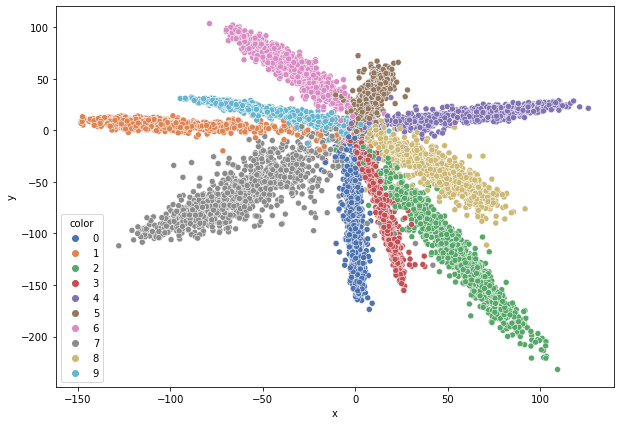

In [103]:
plot_embeddings(embeddings, labels)

_______________

# Triplets

In [114]:
def train_tripletnet(model, device, train_loader, optimizer, epoch, log_interval = 10, dry_run=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = tuple(d.cuda() for d in data)
        
        optimizer.zero_grad()        
        outputs = model(*data)
        loss_inputs = outputs
        loss_fn = TripletLoss(1.0)
        
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test_tripletnet(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = tuple(d.cuda() for d in data)
            
            outputs = model(*data)

            loss_inputs = outputs
            loss_fn = TripletLoss(1.0)

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [118]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 10
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda: 
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
triplet_train_dataset = TripletMNIST(dataset1)
triplet_test_dataset = TripletMNIST(dataset2)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, **train_kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, **test_kwargs)

embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_tripletnet(model, device, triplet_train_loader, optimizer, epoch, log_interval)
    test_tripletnet(model, device, triplet_test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn_triplet.pt")

/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.000262
Train Epoch: 1 [300/60000 (11%)]	Loss: 0.397293
Train Epoch: 1 [600/60000 (21%)]	Loss: 0.330138
Train Epoch: 1 [900/60000 (32%)]	Loss: 0.140590
Train Epoch: 1 [1200/60000 (43%)]	Loss: 0.168104
Train Epoch: 1 [1500/60000 (53%)]	Loss: 0.168406
Train Epoch: 1 [1800/60000 (64%)]	Loss: 0.231768
Train Epoch: 1 [2100/60000 (75%)]	Loss: 0.280070
Train Epoch: 1 [2400/60000 (85%)]	Loss: 0.085788
Train Epoch: 1 [2700/60000 (96%)]	Loss: 0.179293

Test set: Average loss: 0.0020

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.079081
Train Epoch: 2 [300/60000 (11%)]	Loss: 0.193475
Train Epoch: 2 [600/60000 (21%)]	Loss: 0.043576
Train Epoch: 2 [900/60000 (32%)]	Loss: 0.242381
Train Epoch: 2 [1200/60000 (43%)]	Loss: 0.025089
Train Epoch: 2 [1500/60000 (53%)]	Loss: 0.069596
Train Epoch: 2 [1800/60000 (64%)]	Loss: 0.084835
Train Epoch: 2 [2100/60000 (75%)]	Loss: 0.106030
Train Epoch: 2 [2400/60000 (85%)]	Loss: 0.082352
Train Epoch: 2 [2700/60000 (96%)]	Loss: 0.069424



In [119]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)
embeddings, labels = calc_embeddings(model, device, test_loader)

100%|██████████| 10000/10000 [00:07<00:00, 1419.13it/s]


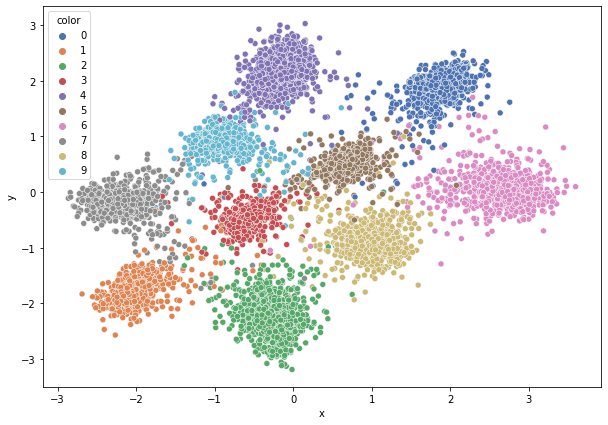

In [120]:
plot_embeddings(embeddings, labels)

### Test it on pre-trained embedding net

In [121]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 10
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = Net().to(device)
# model = ClassifyNet(EmbedNet().to(device)).to(device)
embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.459039
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.902424
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.858407
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.608210
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.618130
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.763404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.356416
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.243306
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.333655
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.217885

Test set: Average loss: 1.2066, Accuracy: 4367/10000 (44%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.429932
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.047575
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.059497
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.163619
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.106913
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.265301
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.816328
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.766760
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.714780
T

In [122]:
seed = 7
batch_size = 64
test_batch_size = 64
use_cuda = True
lr = 1e-4
gamma = 0.9
epochs = 10
save_model = True
log_interval = 100

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda: 
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('mnist/', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('mnist/', train=False,
                   transform=transform)
triplet_train_dataset = TripletMNIST(dataset1)
triplet_test_dataset = TripletMNIST(dataset2)
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, **train_kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, **test_kwargs)

# load pretrained embedding model
model = TripletNet(model.embedding_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train_tripletnet(model, device, triplet_train_loader, optimizer, epoch, log_interval)
    test_tripletnet(model, device, triplet_test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), "mnist_cnn_triplet.pt")

/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Train Epoch: 1 [0/60000 (0%)]	Loss: 312.816528
Train Epoch: 1 [300/60000 (11%)]	Loss: 22.742779
Train Epoch: 1 [600/60000 (21%)]	Loss: 132.200302
Train Epoch: 1 [900/60000 (32%)]	Loss: 3.608844
Train Epoch: 1 [1200/60000 (43%)]	Loss: 19.845657
Train Epoch: 1 [1500/60000 (53%)]	Loss: 0.690201
Train Epoch: 1 [1800/60000 (64%)]	Loss: 21.989948
Train Epoch: 1 [2100/60000 (75%)]	Loss: 6.704533
Train Epoch: 1 [2400/60000 (85%)]	Loss: 3.316361
Train Epoch: 1 [2700/60000 (96%)]	Loss: 2.436590

Test set: Average loss: 0.0572

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.286894
Train Epoch: 2 [300/60000 (11%)]	Loss: 1.096012
Train Epoch: 2 [600/60000 (21%)]	Loss: 6.672297
Train Epoch: 2 [900/60000 (32%)]	Loss: 0.724487
Train Epoch: 2 [1200/60000 (43%)]	Loss: 0.885943
Train Epoch: 2 [1500/60000 (53%)]	Loss: 1.665668
Train Epoch: 2 [1800/60000 (64%)]	Loss: 0.917138
Train Epoch: 2 [2100/60000 (75%)]	Loss: 0.858191
Train Epoch: 2 [2400/60000 (85%)]	Loss: 0.853330
Train Epoch: 2 [2700/60000 (96%)]	Loss: 0.1

In [123]:
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1)
embeddings, labels = calc_embeddings(model, device, test_loader)

100%|██████████| 10000/10000 [00:07<00:00, 1348.47it/s]


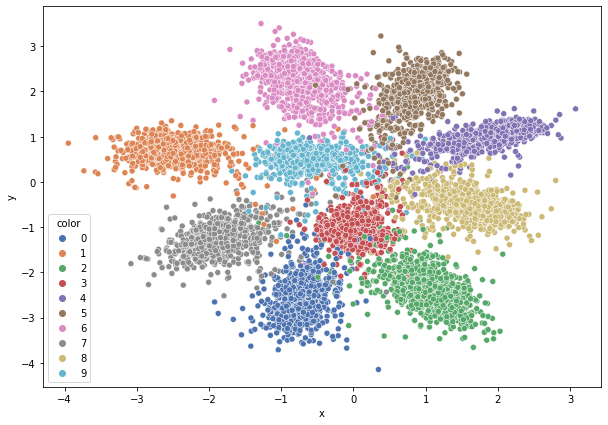

In [124]:
plot_embeddings(embeddings, labels)